# Assignment 3: Character-Level Recurrent Neural Network by PyTorch

In this assignment, you are required to implement Character-Level RNN just as we have learned in the class. However, the difference is we use another dataset in this assignment.

Read through the tutorial [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) that builds a char-rnn that is used to classify names by their country of origin, which is introduced in the class. It is recommended that you can reproduce the tutorial’s results on the provided name dataset before moving on (notebook for Lecture 7), since the neural network architectures remain largely the same. Make sure you try your best to understand the dimensions of each layer (e.g. which ones can stay the same, and which are hyperparameters for us to tweak).

The process will be broken down into the following steps:
>1. Code implementation. (20 marks)
2. Experimentation and analysis (80 marks)

In [2]:
#Download and unzip files
!pip3 install scikit-learn
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
# !sudo apt-get install unzip
!unzip cities_val.zip 
!unzip cities_train.zip
import torch
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

--2022-11-17 11:20:02--  http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
正在解析主机 computational-linguistics-class.org (computational-linguistics-class.org)... 185.199.110.153
正在连接 computational-linguistics-class.org (computational-linguistics-class.org)|185.199.110.153|:80... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：10973 (11K) [text/plain]
正在保存至: “cities_test.txt”

cities_test.txt     100%[===================>]  10.72K  4.32KB/s  用时 2.5s      

2022-11-17 11:20:05 (4.32 KB/s) - 已保存 “cities_test.txt” [10973/10973])

--2022-11-17 11:20:05--  http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
正在解析主机 computational-linguistics-class.org (computational-linguistics-class.org)... 185.199.110.153
正在连接 computational-linguistics-class.org (computational-linguistics-class.org)|185.199.110.153|:80... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：7558 (7.4K) [application/zip]
正在保存至: “cities_val.zip”

cities_val.zip      100%[===================>]   7.38K  --.-KB/s

In [3]:
#Verfiy file download
!head train/af.txt
!printf "\n"
!head val/af.txt
!printf "\n"
!head cities_test.txt
!printf "\n"
#Verify CUDA acceleration should print cuda:0
print(device)

garavshakh
kalishli
sarban kelay
dahan-e surunah
jahannum
morafeno
iskatel
zeri-chinar
taftebole
dzhafarabat

sikhtopa
laferronay
cham ghafur
souk tafetecht
panqash
siah sar bala
barah khan kili
vetob
kacari
kolga'i-i-bala

imam bakhsh amar
firoz laghari
glufishevo
qal`eh-ye ghazanfarkhani
nikolinalevada
kolkko
mbrostar i fierit
kharabanan-e sofla
stein bei nurnberg
jahangir bara

cpu


## Code Implementation (20 marks)

**You should implement all the following functions and you are not allowed to delete any of them. Of course you can add more functions based on this skeleton.**

In [45]:
#main_classify.py
import codecs
import math
import random
import unicodedata
import string
import time
import numpy as np
import torch
from sklearn.metrics import accuracy_score

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"

'''
Returns the words of the language specified by reading it from the data folder
Returns the validation data if train is false and the train data otherwise.
Return: A nx1 array containing the words of the specified language
'''
# 下载训练数据可发现编码不一，Unicode转换为ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
# print(unicodeToAscii('Ślusàrski'))

# 读取文件
def getWords(baseDir, lang, train = True):
    if train:
        path = 'train/'
    else:
        path = 'val/'
    with open(baseDir + path + lang + '.txt', encoding='utf-8', errors='ignore') as file:
        lines = file.read().strip().split('\n')  # 按行分割每一条数据
    return [unicodeToAscii(line) for line in lines]
# print(getWords('', 'af'))
    

'''
Returns a label corresponding to the language
For example it returns an array of 0s for af
Return: A nx1 array as integers containing index of the specified language in the "languages" array
'''
def getLabels(lang, length):
    # 找到lang在languages中对应的索引
    for i in range(len(languages)):
        if languages[i] == lang:
            index = i
    # 全部打上index标签
    labels = [index for _ in range(length)]
    return labels
# print(getLabels('af', 5))

'''
Returns all the laguages and labels after reading it from the file
Returns the validation data if train is false and the train data otherwise.
You may assume that the files exist in baseDir and have the same names.
Return: X, y where X is nx1 and y is nx1
'''
def readData(baseDir, train=True):
    X = []
    y = []
    for lang in languages:
        # 获取该文件所有的词 getWords根据train返回train或val
        words = getWords(baseDir, lang, train)
        # 获取所有的标签
        labels = getLabels(lang, len(words))
        X += words
        y += labels
    return X, y

'''
Convert a line/word to a pytorch tensor of numbers
Refer the tutorial in the spec
Return: A tensor corresponding to the given line
'''
def line_to_tensor(line):
    # 一行的长度
    line_length = len(line)
    # 字母字符表长度
    letter_length = len(all_letters)
    # 创建一个line_length*1*letter_length的tensor
    line_tensor = torch.zeros(line_length, 1, letter_length, dtype=torch.float)
    for li, letter in enumerate(line):
        # 找到letter在字符表中的位置并且在tensor中设为1
        line_tensor[li][0][all_letters.find(letter)] = 1
    return line_tensor
# print(line_to_tensor('zhujia dawan'))

'''
Returns the category/class of the output from the neural network
Input: Output of the neural networks (class probabilities)
Return: A tuple with (language, language_index)
        language: "af", "cn", etc.
        language_index: 0, 1, etc.
'''
def category_from_output(output):
    # 获取输出结果中按行最大值 即预测的语言类别  
    _, predict = output.topk(1)
    # 获取索引
    index = predict[0].item() 
    # 匹配语言类型
    lang = languages[index]
    return (lang, index)

'''
Get a random input output pair to be used for training 
Refer the tutorial in the spec
'''
def random_choice(X):
    # 随机产生一个符合规定的行索引
    index = random.randint(0, len(X) - 1)
    return X[index], index
def random_training_pair(X, y):
    # 随机获取X中的一行以及对应索引
    line, index = random_choice(X)
    line_tensor = line_to_tensor(line)
    # 语言类别
    label = y[index]
    label_tensor = torch.zeros(len(languages), dtype=float)
    label_tensor[label] = 1
    return label, line, label_tensor, line_tensor
    
'''
Input: trained model, a list of words, a list of class labels as integers
Output: a list of class labels as integers
'''
def predict(model, X):
    pre = []
    # 获取初始的隐藏层
    hidden_layer = model.init_hidden()
    length = len(X)
    # 遍历每一行
    for i in range(length):
        line_tensor = line_to_tensor(X[i])
        # 遍历每个字符
        for j in range(line_tensor.size()[0]):
            output, hidden_layer = model(line_tensor[j], hidden_layer)
        output = torch.max(output, 1)[1]  
        pre.append(output[0])
    return pre

'''
Input: trained model, a list of words, a list of class labels as integers
Output: The accuracy of the given model on the given input X and target y
'''
def calculateAccuracy(model, X, y):
    # 利用sklearn计算准确率
    y_pre = predict(model, X)
    return accuracy_score(y, y_pre)

'''
Train the model for one epoch/one training word.
Ensure that it runs within 3 seconds.
Input: X and y are lists of words as strings and classes as integers respectively
Returns: You may return anything
'''
def trainOneEpoch(model, criterion, optimizer, X, y):
    # 隐层 
    hidden = model.init_hidden()
    # 获得随机行
    label, line, label_tensor, line_tensor = random_training_pair(X, y)
    # 梯度置0
    optimizer.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    label_tensor = label_tensor.view(1, len(languages))
    # 计算损失
    loss = criterion(output, torch.max(label_tensor, 1)[1])
    # 反向传播
    loss.backward()
    optimizer.step()
    return output, loss.item(), label, line, model

'''
Use this to train and save your classification model. 
Save your model with the filename "model_classify"
'''
# 读取训练集和测试集数据
X, y = readData("./", train=True)
val_X, val_y = readData('./', train=False)

# 参数设置
n_letters = len(all_letters)
n_hidden = 128
n_languages = len(languages)
learning_rate = 0.0005
def run():
    # 部分训练参数
    n_iters = 100000  # 训练次数
    print_every = 5000  # 每5000次打印训练信息
    plot_every = 1000  # 每1000次绘制训练信息

    # 建立网络
    char_rnn = CharRNNClassify(n_letters, n_hidden, n_languages)
    criterion = nn.NLLLoss()  # 损失函数
    optimizer = torch.optim.Adam(char_rnn.parameters(), lr=learning_rate)  # 优化器

    # 记录训练损失
    current_loss = 0
    all_losses = []
    # 记录验证损失
    val_current_loss = 0
    val_all_losses = []

    # 记录运行时间
    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)
    start = time.time()

    # 训练
    for iter in range(1, n_iters+1):
        output, loss, label, line, char_rnn = trainOneEpoch(char_rnn, criterion, optimizer, X, y)
        current_loss += loss
      
        # 参考Lecture7.ipynb：打印epoch, loss, name, guess 
        if iter % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == languages[label] else '✗ (%s)' % languages[label]
            print('%d %d%% (%s) %.4f %s / %s %s' % (
              iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # 验证模型
        _, _, val_label_tensor, val_line_tensor = random_training_pair(val_X, val_y)
        hidden = char_rnn.init_hidden()
        for i in range(val_line_tensor.size()[0]):
            val_output, hidden = char_rnn(val_line_tensor[i], hidden)
        val_category_tensor = val_label_tensor.view(1, n_languages)
        val_loss = criterion(val_output, torch.max(val_category_tensor, 1)[1]).item()
        val_current_loss += val_loss
        
        # 记录损失
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            val_all_losses.append(val_current_loss / plot_every)
            current_loss = 0
            val_current_loss = 0
    # 准确率
    acc = calculateAccuracy(char_rnn, val_X, val_y)
    if iter % print_every == 0:
        print('Validation Accuracy: ', acc)
    # 模型保存
    torch.save(char_rnn.state_dict(), './model_classify.pth')
    return all_losses, val_all_losses

In [46]:
#models.py
import torch.nn as nn
from torch.autograd import Variable
import torch
import torch.nn.functional as F

'''
Please add default values for all the parameters of __init__.
'''
# 网络结构参考Lecture7.ipynb
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNNClassify, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden=None):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.tanh(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

## Experimentation and Analysis (80 marks)

Complete the following analysis on the city names dataset.

1. Write code to output accuracy on the validation set (10 marks).  Use a confusion matrix plot to support your answer (10 marks).

In [47]:
# 训练
all_losses, val_all_losses = run()

5000 5% (0m 6s) 1.7985 muelle real de siquia / za ✗ (de)
10000 10% (0m 13s) 0.8304 seyyed jowzar / za ✓
15000 15% (0m 20s) 1.1994 paijala / fi ✓
20000 20% (0m 26s) 0.7060 lampopera / fi ✓
25000 25% (0m 33s) 0.5231 ali muhammad khoso / pk ✓
30000 30% (0m 40s) 1.7905 guge / in ✗ (cn)
35000 35% (0m 47s) 0.9388 pata de res / de ✓
40000 40% (0m 53s) 1.0504 barj aziz khan / pk ✓
45000 45% (1m 0s) 0.1911 guangyi / cn ✓
50000 50% (1m 7s) 3.1521 desran / de ✗ (in)
55000 55% (1m 13s) 0.2792 ummat sifi / fi ✓
60000 60% (1m 20s) 2.4653 tyngiza / cn ✗ (za)
65000 65% (1m 27s) 0.2444 demleva / de ✓
70000 70% (1m 33s) 0.3424 chah munirwala / pk ✓
75000 75% (1m 40s) 3.0190 zer gul talao / za ✗ (pk)
80000 80% (1m 47s) 0.6411 neuholtum in der marsch / de ✓
85000 85% (1m 53s) 4.5477 mvoti location / in ✗ (za)
90000 90% (2m 0s) 0.5961 dashte lokhak / af ✓
95000 95% (2m 7s) 2.3957 shiliuqing / cn ✗ (in)
100000 100% (2m 13s) 0.1456 chichen / cn ✓
Validation Accuracy:  0.6033333333333334


/var/folders/6v/1vc6xqrj50z821lfdf9n32mc0000gn/T/ipykernel_69785/2926284089.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + languages, rotation=90)
/var/folders/6v/1vc6xqrj50z821lfdf9n32mc0000gn/T/ipykernel_69785/2926284089.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + languages)


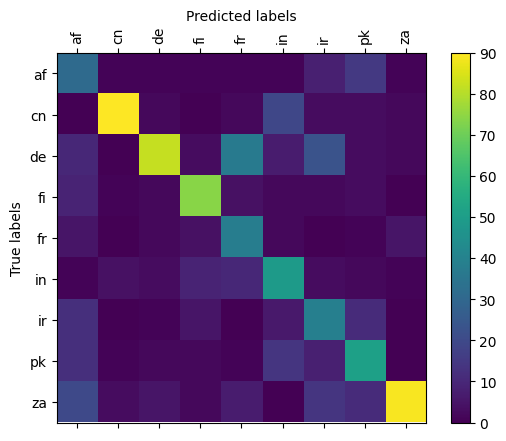

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix

model = CharRNNClassify(n_letters, n_hidden, n_languages)
model.load_state_dict(torch.load('./model_classify.pth'))
model.eval()
# 计算混淆矩阵
y_pre = predict(model, val_X)
conf_matrix = confusion_matrix(y_pre, val_y)

# 建立画布
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
fig.colorbar(cax)

# 建立坐标轴
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# 更改坐标轴名称
ax.set_xlabel('Predicted labels')
ax.xaxis.set_label_position('top')
ax.set_ylabel('True labels')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

2. Periodically compute the loss on the validation set, and create a plot with the training and validation loss as training progresses (20 marks).

1000: validation loss:2.134476416528225
2000: validation loss:1.990912114083767
3000: validation loss:1.9003248592019082
4000: validation loss:1.7878942617177964
5000: validation loss:1.7772773454487323
6000: validation loss:1.7556873506754638
7000: validation loss:1.6642328881695867
8000: validation loss:1.656389787659049
9000: validation loss:1.654919106937945
10000: validation loss:1.6298682829253375
11000: validation loss:1.6025209469422699
12000: validation loss:1.5975884281508625
13000: validation loss:1.6198631205298006
14000: validation loss:1.5848451146557927
15000: validation loss:1.530025881865993
16000: validation loss:1.5747003699578346
17000: validation loss:1.4675995054300874
18000: validation loss:1.5167398385740816
19000: validation loss:1.4321480085253715
20000: validation loss:1.511202296094969
21000: validation loss:1.504426289770752
22000: validation loss:1.5528326456286012
23000: validation loss:1.5321024482175707
24000: validation loss:1.5618204798270017
25000: v

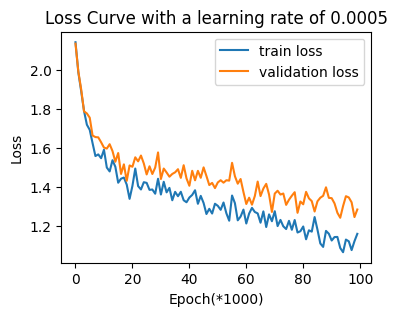

In [55]:
# 输出validation loss
for i in range(1, len(val_all_losses)+1):
    print("{}: validation loss:{}".format(1000*i, val_all_losses[i-1]))
# 绘制训练过程中的loss
def draw_loss(all_losses, val_all_losses, lr):
    plt.figure(figsize=(4, 3))
    plt.plot(all_losses, label='train loss')
    plt.plot(val_all_losses, label='validation loss')
    plt.legend()
    plt.xlabel('Epoch(*1000)')
    plt.ylabel('Loss')
    plt.title('Loss Curve with a learning rate of {}'.format(lr))
    plt.show()
draw_loss(all_losses, val_all_losses, learning_rate)

3. Experiment with the learning rate. You can try a few different learning rates and observe how this affects the loss. Another common practice is to drop the learning rate when the loss has plateaued. Use plots to explain your experiments and their effects on the loss (20 marks).

5000 5% (0m 6s) 3.2155 sajikot / za ✗ (pk)
10000 10% (0m 12s) 74.4197 manacnac / za ✗ (cn)
15000 15% (0m 18s) 45.4168 windsorton / de ✗ (za)
20000 20% (0m 24s) 41.0302 usman bhurgari goth / cn ✗ (pk)
25000 25% (0m 30s) 21.4099 shagasikala / za ✗ (af)
30000 30% (0m 36s) 0.0001 goth aliu khan / pk ✓
35000 35% (0m 42s) 9.1305 qamar ud din khel / in ✗ (af)
40000 40% (0m 48s) 9.0294 hervanta / in ✗ (fi)
45000 45% (0m 54s) 0.0000 darmai / pk ✓
50000 50% (1m 0s) 6.3867 shaomaying / de ✗ (cn)
55000 55% (1m 6s) 6.1800 sorsakoskentehdas / fr ✗ (fi)
60000 60% (1m 12s) 30.3426 khera helu / cn ✗ (in)
65000 65% (1m 18s) 0.0080 biscarosseplage / fr ✓
70000 70% (1m 24s) 14.3131 shuisiling / af ✗ (cn)
75000 75% (1m 30s) 14.2676 chihilmati / fi ✗ (af)
80000 80% (1m 37s) 55.0930 sofiyskoye / ir ✗ (fi)
85000 85% (1m 43s) 16.6731 la zarca / fr ✗ (za)
90000 90% (1m 49s) 0.0802 les bussolleries / fr ✓
95000 95% (1m 55s) 19.3331 chak number fiftyfive / de ✗ (fi)
100000 100% (2m 1s) 16.4559 vinh vue ni / cn ✗ 

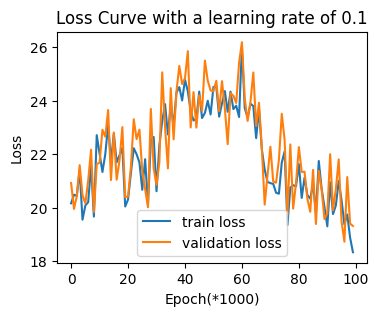

5000 5% (0m 6s) 1.3723 feuguerollessurseulles / fi ✗ (fr)
10000 10% (0m 12s) 0.5419 haimps / fr ✓
15000 15% (0m 18s) 3.0549 zeiwa / fi ✗ (ir)
20000 20% (0m 24s) 4.0016 goth gita jo / cn ✗ (pk)
25000 25% (0m 30s) 3.6491 liudafang / cn ✗ (af)
30000 30% (0m 36s) 9.2489 cafifi / fi ✗ (af)
35000 35% (0m 42s) 3.2735 de nazar mohammad kor / af ✗ (za)
40000 40% (0m 48s) 4.0495 char baghe seyyedan / cn ✗ (af)
45000 45% (0m 54s) 7.4616 mohanlalganj / af ✗ (in)
50000 50% (1m 0s) 6.3485 kaochiachen / in ✗ (cn)
55000 55% (1m 6s) 6.5606 qianbatouzi / af ✗ (cn)
60000 60% (1m 13s) 3.5500 khaydarabad / fr ✗ (af)
65000 65% (1m 19s) 5.3425 gambiroza / in ✗ (ir)
70000 70% (1m 25s) 5.4630 tzutussu / in ✗ (cn)
75000 75% (1m 31s) 7.4640 piriiasul / de ✗ (ir)
80000 80% (1m 37s) 4.4141 chupingtzu / cn ✗ (in)
85000 85% (1m 43s) 1.3596 esmullah / de ✗ (af)
90000 90% (1m 49s) 3.3028 dengjiafa / za ✗ (af)
95000 95% (1m 55s) 5.2181 rajajoki / in ✗ (fi)
100000 100% (2m 1s) 3.4144 kharestan / fi ✗ (af)
Validation Acc

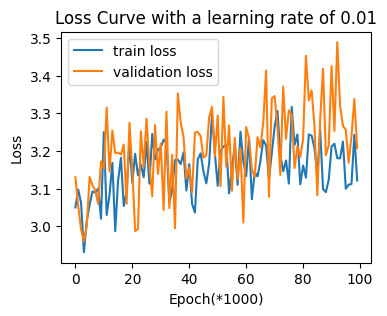

5000 5% (0m 6s) 1.6377 puy de corn / de ✗ (fr)
10000 10% (0m 12s) 0.5947 shah kili / pk ✓
15000 15% (0m 18s) 1.8249 santa cristina do couto / de ✗ (in)
20000 20% (0m 24s) 2.4113 duringer weg / de ✗ (in)
25000 25% (0m 30s) 1.9737 lalafuta / fi ✗ (af)
30000 30% (0m 36s) 0.6294 liaoyuansi / cn ✓
35000 35% (0m 43s) 0.1917 tsaihsiatsun / cn ✓
40000 40% (0m 49s) 1.1961 tangizardak / za ✓
45000 45% (0m 55s) 2.5153 saintthomas / in ✗ (fr)
50000 50% (1m 1s) 0.7526 tashkar / pk ✓
55000 55% (1m 7s) 0.9351 abou mannsaf / af ✓
60000 60% (1m 13s) 1.3537 karize sar cheshmeh / ir ✗ (af)
65000 65% (1m 20s) 0.1085 kampinkyla / fi ✓
70000 70% (1m 26s) 0.8043 goth mir muhammad sabki / pk ✓
75000 75% (1m 32s) 0.5765 keyan zarma / za ✓
80000 80% (1m 38s) 1.5414 raffou / fi ✗ (af)
85000 85% (1m 44s) 0.5097 hsisunchialou / cn ✓
90000 90% (1m 50s) 6.2590 deir hafir / fi ✗ (de)
95000 95% (1m 56s) 2.2035 markusbole / za ✗ (fi)
100000 100% (2m 2s) 1.6005 gavan kala / pk ✗ (ir)
Validation Accuracy:  0.387777777777

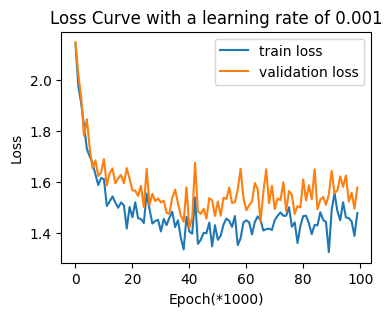

5000 5% (0m 6s) 2.1656 villa siqueira / in ✗ (ir)
10000 10% (0m 12s) 0.3489 fanchiangshih / cn ✓
15000 15% (0m 18s) 4.2427 sankt heinrich / fi ✗ (de)
20000 20% (0m 24s) 1.3546 fridingen / de ✓
25000 25% (0m 30s) 0.6072 ghargharaw / af ✓
30000 30% (0m 36s) 0.6409 finnshogst / fi ✓
35000 35% (0m 42s) 0.4462 tsyganskaya zarya / za ✓
40000 40% (0m 48s) 1.1420 bagh zarein / ir ✓
45000 45% (0m 54s) 0.5985 aspindza / za ✓
50000 50% (1m 0s) 2.1616 abdulkadirkoy / fr ✗ (ir)
55000 55% (1m 6s) 1.3671 pestaikalan / af ✓
60000 60% (1m 12s) 0.2159 dembe toccolu / de ✓
65000 65% (1m 18s) 1.5447 michlhausen / de ✓
70000 70% (1m 25s) 0.4569 kleinhabersdorf / de ✓
75000 75% (1m 31s) 0.2687 qazan qeshlaq / za ✓
80000 80% (1m 37s) 3.0287 alpuderesi koyu / ir ✗ (de)
85000 85% (1m 43s) 1.2502 mamrez pathan / pk ✓
90000 90% (1m 49s) 2.1038 kafr yahud / fr ✗ (af)
95000 95% (1m 55s) 0.9249 tsuimiao / cn ✓
100000 100% (2m 1s) 0.8956 kalaakhingar / af ✓
Validation Accuracy:  0.5333333333333333


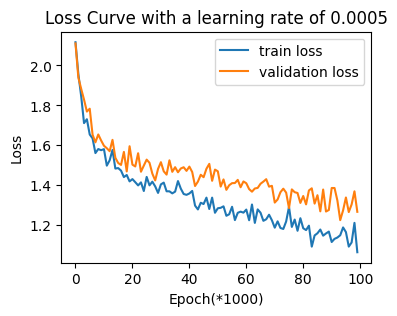

5000 5% (0m 6s) 2.9336 sitio mario ferreira / in ✗ (ir)
10000 10% (0m 12s) 0.6413 fortin zalazar / za ✓
15000 15% (0m 18s) 0.5284 pizza / za ✓
20000 20% (0m 24s) 2.1468 atial / in ✗ (pk)
25000 25% (0m 30s) 0.8317 montalery / fr ✓
30000 30% (0m 36s) 0.9690 pousadinha / in ✓
35000 35% (0m 42s) 1.3495 luopinghe / cn ✗ (in)
40000 40% (0m 48s) 1.6482 lalungdeng / de ✗ (cn)
45000 45% (0m 54s) 0.5185 naungyin lwin / in ✓
50000 50% (1m 0s) 1.3021 sardau / af ✓
55000 55% (1m 6s) 1.6823 patakan / af ✗ (pk)
60000 60% (1m 12s) 4.0637 berera / de ✗ (pk)
65000 65% (1m 18s) 1.2014 novozaprudnoye / fr ✗ (za)
70000 70% (1m 24s) 0.5160 shumfida / fi ✓
75000 75% (1m 30s) 1.1938 umarwal / af ✗ (pk)
80000 80% (1m 37s) 2.7212 triomf / fi ✗ (za)
85000 85% (1m 43s) 1.1970 dehe rajab / de ✗ (af)
90000 90% (1m 49s) 0.5754 ylakiviranta / fi ✓
95000 95% (1m 55s) 0.7464 kuzah khermanah / za ✓
100000 100% (2m 1s) 0.6332 dahane ahanfolad / af ✓
Validation Accuracy:  0.6033333333333334


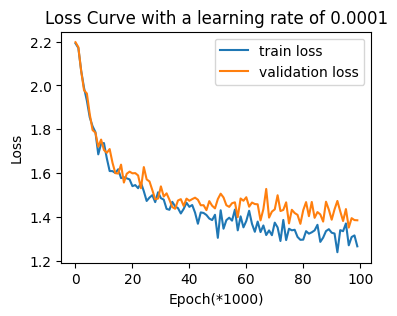

In [43]:
# 训练 lr=0.1
learning_rate = 0.1
all_losses, val_all_losses = run()
draw_loss(all_losses, val_all_losses, learning_rate)
# 训练 lr=0.01
learning_rate = 0.01
all_losses, val_all_losses = run()
draw_loss(all_losses, val_all_losses, learning_rate)
# 训练 lr=0.001
learning_rate = 0.001
all_losses, val_all_losses = run()
draw_loss(all_losses, val_all_losses, learning_rate)
# 训练 lr=0.0005
learning_rate = 0.0005
all_losses, val_all_losses = run()
draw_loss(all_losses, val_all_losses, learning_rate)
# 训练 lr=0.0001
learning_rate = 0.0001
all_losses, val_all_losses = run()
draw_loss(all_losses, val_all_losses, learning_rate)

Answer:通过设置不同的学习率（0.1, 0.01, 0.001, 0.0005, 0.0001）进行多组对比实验，可以发现当学习率在一个较高的值时，比如0.1，0.01，loss曲线极不稳定，不能稳定下降，甚至有上升的现象，也就是说模型在搞学习率下不能较好地学习，同时根据先验知识，文本分类问题的学习率一般不会高于0.001，这在实验中也得到了验证，当模型以低于0.001的学习率进行学习时，loss曲线整体呈下降趋势，通过对比发现在该实验中0.0005以及0.0001的学习率loss曲线稳定下降，表明模型学习效果较好，同时在提高时间效率的情况下可以选择0.0005的学习率，时间较充分的情况下可选0.0001的学习率。

4. Experiment with the size of the hidden layer or the model architecture How does this affect validation accuracy (20 marks)?

In [44]:
# 训练 hidden_size=32
learning_rate = 0.0005
n_hidden = 32
all_losses, val_all_losses = run()
# 训练 hidden_size=64
n_hidden = 64
all_losses, val_all_losses = run()
# 训练 hidden_size=128
n_hidden = 128
all_losses, val_all_losses = run()
# 训练 hidden_size=256
n_hidden = 256
all_losses, val_all_losses = run()
# 训练 hidden_size=512
n_hidden = 512
all_losses, val_all_losses = run()

5000 5% (0m 4s) 1.9867 polans / in ✗ (fi)
10000 10% (0m 9s) 1.6546 shahid davud hadian / pk ✗ (ir)
15000 15% (0m 14s) 1.6275 sardrud / de ✗ (ir)
20000 20% (0m 18s) 1.0507 sudweyhe / de ✓
25000 25% (0m 23s) 0.9911 williers / fr ✓
30000 30% (0m 28s) 0.6910 espiute / fr ✓
35000 35% (0m 32s) 4.2290 punun / cn ✗ (pk)
40000 40% (0m 37s) 0.8384 la mision de los angeles / fr ✗ (de)
45000 45% (0m 42s) 0.4428 lufico / fi ✓
50000 50% (0m 47s) 2.5885 shengesh / de ✗ (af)
55000 55% (0m 51s) 1.6375 inkunzana / in ✗ (za)
60000 60% (0m 56s) 4.0662 yazdu / za ✗ (ir)
65000 65% (1m 1s) 0.9156 steinreinach / de ✓
70000 70% (1m 5s) 2.1526 bronca / de ✗ (fr)
75000 75% (1m 10s) 0.0775 gayugang / cn ✓
80000 80% (1m 15s) 0.7789 bonkende / de ✓
85000 85% (1m 19s) 0.6690 batougou / cn ✓
90000 90% (1m 24s) 0.6879 shadu khan / pk ✓
95000 95% (1m 29s) 0.7136 cabeza cuervo / za ✓
100000 100% (1m 34s) 1.1459 kerbor'hel / fr ✓
Validation Accuracy:  0.56
5000 5% (0m 4s) 1.1699 erloy / fr ✓
10000 10% (0m 9s) 2.1505 novo

Answer:在学习率为0.0005情况下，通过改变隐含层的大小（32，64，128，156，512）来进行对比实验，可以发现验证集准确率(32=>0.56,  64=>0.613, 128=>0.623, 256=>0.427, 512=>0.187)，整体呈现先上升后下降的趋势，在隐含层大小为128时达到最大值，因此隐含层大小的选取，既不能过大也不能过小，要保持在一个适中的值。